<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/main/part-1/Death%20prediction/Closest%20point/part1_model_based_knn_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNetCV,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [98]:
oppScrData = pd.read_excel(r'sample_data/OppScrData.xlsx')

In [99]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    cols = ["L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'DEATH [d from CT]']
    ct_data= oppScrData[cols]
    n = ct_data.shape[0]
    preprocessed_ct_data = pd.DataFrame( columns=cols)
    for i in range(n):
        row = ct_data.loc[i]
        ignore = False
        for k,j in enumerate(row):
          if pd.isna(j) or j == ' ': 
            if k == 11:              
              ignore = False
            else:
              ignore = True
              break
        if not ignore:
          preprocessed_ct_data.loc[i]= row
    return preprocessed_ct_data

In [100]:
def preprocess_clinical_data(oppScrData, mean=True):
    
    l = ['BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'Age at CT', 'CVD DX', 'Heart failure DX',
                                       'MI DX','Type 2 Diabetes DX', 'Primary Cancer Site', 'Humerus fracture DX',
                                       'Femoral neck fracture DX', 'Unspec femoral fracture DX', 'Forearm fracture DX'
                                       ,'Primary Cancer Site 2','Pathologic fracture DX','DEATH [d from CT]']

    clinical_data = oppScrData.filter(l, axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 

    for col in l[l.index('CVD DX'):l.index('DEATH [d from CT]')]:      
      clinical_data.loc[clinical_data[col].notna(), col] = 1
      clinical_data[col].fillna(value=0, inplace=True)
  
    return clinical_data

In [101]:
def testWithModel(model, X_train, X_test, y_train, y_test):
  clf = model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print_error(y_pred, y_test)
  plot_results(y_pred, y_test)

  return y_pred

In [102]:
def plot_results(y_pred, y_test, z=15):
  plt.figure()
  y_test_sub, y_pred_sub = y_test, y_pred
  if len(y_test)>200:
    y_test_sub, y_pred_sub = y_test[::z], y_pred[::z]
    
  x = [i+1 for i in range(len(y_test_sub))]
  plt.plot((x,x),([i for i in y_pred_sub], [j for j in y_test_sub]),c='green',markevery=5,)
  plt.scatter(x, y_pred_sub, label="predicted_y")
  plt.scatter(x, y_test_sub, label="actual_y")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.legend()
  plt.show()

In [103]:
def print_error(y_pred, y_test):
  print(f'MAE = {mean_absolute_error(y_pred, y_test)}')
  print(f'MAPE = {mean_absolute_percentage_error(y_pred, y_test)}')
  print(f'RMSE = {mean_squared_error(y_pred, y_test)**0.5}')

In [104]:
clinical_data = preprocess_clinical_data(oppScrData)

In [105]:
sc = StandardScaler()

non_null_death_rows = clinical_data[~clinical_data['DEATH [d from CT]'].isnull()]

# Convert to years
non_null_death_rows['DEATH [d from CT]'] /= 365

m = non_null_death_rows.columns.get_loc('DEATH [d from CT]')

X = non_null_death_rows.iloc[:, 0:m]
y = non_null_death_rows.iloc[:, m]
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Train

In [106]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

knn = KNeighborsRegressor()
param_grid2 = dict(weights = ["uniform", "distance"], n_neighbors=list(range(2, 14)))
    
grid = GridSearchCV(knn, param_grid2)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print_error(y_pred, y_test)

print(grid.best_params_)

MAE = 3.1831589871315904
MAPE = 0.5285452056894119
RMSE = 3.764249421924367
{'n_neighbors': 12, 'weights': 'uniform'}


In [ ]:
clinical_data = preprocess_clinical_data(oppScrData)

for idx, row in clinical_data.iterrows():  
  if np.isnan(clinical_data.at[idx,'DEATH [d from CT]']):
    l = ['BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'Age at CT', 'CVD DX', 'Heart failure DX',
                                       'MI DX','Type 2 Diabetes DX', 'Primary Cancer Site', 'Humerus fracture DX',
                                       'Femoral neck fracture DX', 'Unspec femoral fracture DX', 'Forearm fracture DX'
                                       ,'Primary Cancer Site 2','Pathologic fracture DX']
    row = clinical_data.iloc[idx]     
    r = row.filter(l).to_numpy().reshape(1, -1) 
    clinical_data.at[idx,'DEATH [d from CT]'] = (grid.predict(r))
  else:
    clinical_data.at[idx,'DEATH [d from CT]'] /= 365

In [108]:
oppScrData['DEATH [d from CT]'] = clinical_data['DEATH [d from CT]']

In [109]:
ct_data = clean_ct_data(oppScrData=oppScrData)

Build Regressor

In [110]:
y = ct_data.iloc[:,11]
X = ct_data.iloc[:, 0:11]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

In [111]:
print(X.shape)

(8878, 11)


MAE = 0.44835600440623263
MAPE = 0.08992715679864408
RMSE = 0.9514923591408837


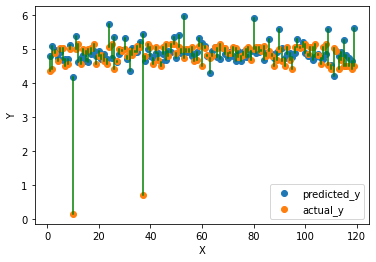

In [112]:
knn = KNeighborsRegressor(n_neighbors=9)
param_grid2 = dict(weights = ["uniform", "distance"])
knn_pred = testWithModel(GridSearchCV(knn, param_grid2),X_train, X_test, y_train, y_test)

MAE = 0.4481462886408992
MAPE = 0.09035695262824568
RMSE = 0.9285614407192051


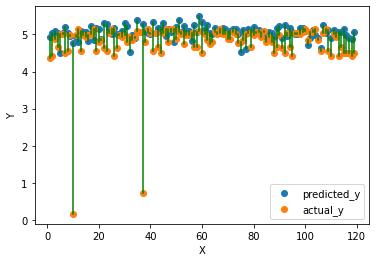

In [113]:
svr_pred = testWithModel(SVR(C=300, epsilon=0.8),X_train, X_test, y_train, y_test)

MAE = 0.3708636752888267
MAPE = 0.0747572371915044
RMSE = 0.8951509997078544


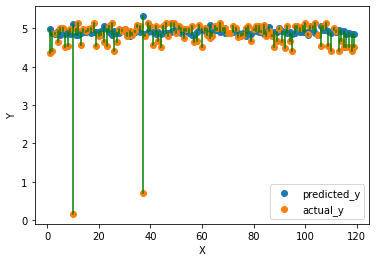

In [114]:
lasso_pred = testWithModel(Lasso(alpha=0.1), X_train, X_test, y_train, y_test)

MAE = 0.37059044938641067
MAPE = 0.07471915522509741
RMSE = 0.8951998768640019


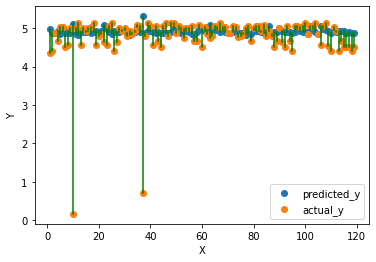

In [115]:
elastic_net_pred = testWithModel(ElasticNetCV(random_state=0), X_train, X_test, y_train, y_test)

MAE = 0.6070264613928997
MAPE = 0.13538604540677562
RMSE = 1.3965281695969245


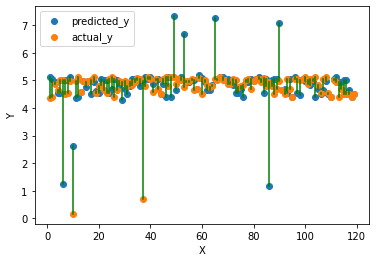

In [116]:
dtree_pred = testWithModel(DecisionTreeRegressor(criterion="absolute_error"),X_train, X_test, y_train, y_test)

MAE = 0.38103605441222294
MAPE = 0.07648961825876599
RMSE = 0.8931202058753775


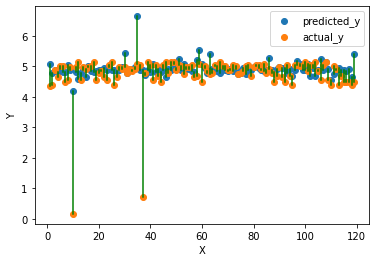

In [123]:
RFparams2={'n_estimators':[70],
          'min_samples_split':[20],
          'min_samples_leaf': [4],
           'max_features': [11],
           'max_depth': [15],
           'bootstrap': [True]}

rf = RandomForestRegressor(random_state = 21)
clf_random_forest = GridSearchCV(rf, RFparams2, refit=True)

rf_pred = testWithModel(clf_random_forest ,X_train, X_test, y_train, y_test)


Build Ensemble

In [124]:
array_preds = np.array([elastic_net_pred, knn_pred, svr_pred, lasso_pred, dtree_pred, rf_pred])

Average of all predictions

In [125]:
y_ens_avg = np.mean((array_preds), axis=0 )

MAE = 0.3983150861199314
MAPE = 0.07974161313951152
RMSE = 0.9138425213662609


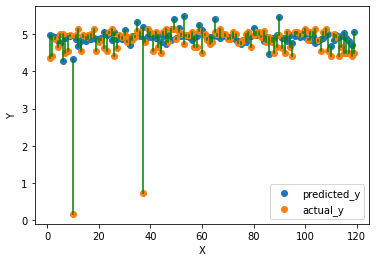

In [126]:
print_error(y_ens_avg, y_test)
plot_results(y_ens_avg, y_test)

Randomly pick a prediction

In [127]:
import random
y_ens=[]

for i,y in enumerate(y_test):

  j = random.randint(0, 4)
  y_ens.append( array_preds[j][i])

MAE = 0.4345543478519126
MAPE = 0.08992593450879867
RMSE = 0.9949974658632661


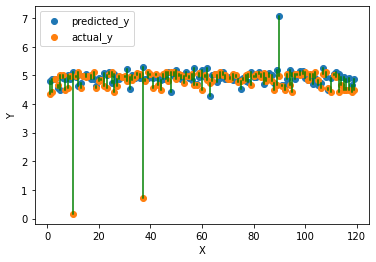

In [128]:
print_error(y_ens, y_test)
plot_results(y_ens, y_test)

Enemble with linear regression

In [129]:
preds_transpose = array_preds.T

In [130]:
X_train_ens, X_test_ens, y_train_ens, y_test_ens  = train_test_split(preds_transpose, y_test, test_size=0.2, random_state=0)

In [131]:
lin_reg = LinearRegression().fit(X_train_ens, y_train_ens)
lin_reg.score(X_test_ens, y_test_ens)

-0.023636637732977972

In [132]:
print(lin_reg.coef_)
print(lin_reg.intercept_)

[-8.374658   -0.16155865  0.02790332  7.34180758 -0.02447514  0.74360036]
7.0840860400016386


In [133]:
y_pred_ens=lin_reg.predict(X_test_ens)

In [134]:
print(len(y_pred_ens))

356


MAE = 0.42875651757535777
MAPE = 0.08804197988134904
RMSE = 1.0614303432665755


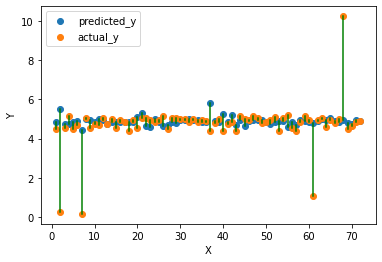

In [135]:
print_error(y_pred_ens, y_test_ens)
plot_results(y_pred_ens, y_test_ens, 5)